**Homework 2:**
Top university rankings


# topuniversities.com section
Strategy for www.topuniversities.com website:
1. Analysis of web traffic after sending GET request shows that basic informations can be retrived just by getting json file from website.
2. We created DataFrame, from json, which contains basic information and urls to details page of every university.
3. Next step was to analyse detail page structure to obtain as much information as we can. This step make use of BeautifulSoup library.
4. In order to get details of each university we iterated through url and nid attributes of basic DataFrame and downloaded detail page together with json file (containing more information)
5. After downloading detail page we extracted details using BeautifulSoup and create DF. We did that with every university concatenating created DF.
6. At the end we merged (joined) both basic and details DF together on url attribute.
7. Cleaning the data was done in required places.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import difflib
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

In [2]:
# Get basic ranking using the same api as website does. Link comes from analysing web traffic after GET request to topunieversities.com website
top_universities_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508409283658'
r = requests.get(top_universities_url).json()


In [3]:
# Take only first 200 records and put them into DataFrame
top_unis = pd.DataFrame.from_dict(r['data'][:200])
top_unis = top_unis[['rank_display', 'title', 'country', 
       'region', 'url', 'nid']]

top_unis.head(5)

,rank_display,title,country,region,url,nid
0,1,Massachusetts Institute of Technology (MIT),United States,North America,/universities/massachusetts-institute-technolo...,294850
1,2,Stanford University,United States,North America,/universities/stanford-university,297282
2,3,Harvard University,United States,North America,/universities/harvard-university,294270
3,4,California Institute of Technology (Caltech),United States,North America,/universities/california-institute-technology-...,294562
4,5,University of Cambridge,United Kingdom,Europe,/universities/university-cambridge,294561


In [4]:
#Create a table with all the details that can be found on a university website 


details = pd.DataFrame()
for url, nid in zip(top_unis['url'].values, top_unis['nid'].values):
    #print(url)

    req = requests.get('https://www.topuniversities.com' + url)
    soup = BeautifulSoup(req.text, 'html.parser')
    req2 = requests.get('https://www.topuniversities.com/qs-profiles/classifications/' + nid).json()

    d = dict()
    d['url'] = url
    try:
        d['Total faculty members'] = int(soup.find("div", class_="total faculty").find("div", class_="number").string.strip().replace(",", ""))
        d['International faculty members'] = int(soup.find("div", class_="inter faculty").find("div", class_="number").string.strip().replace(",", ""))
        d['Total number of students'] = int(soup.find("div", class_="total student").find("div", class_="number").string.strip().replace(",", ""))
        d['Total international students'] = int(soup.find("div", class_="total inter").find("div", class_="number").string.strip().replace(",", ""))
        d['Postgraduate students [%]'] = int(soup.find("div", class_="total student").find("div", class_="post").span.string.strip().replace("%", ""))
        d['Undergraduate students [%]'] = int(soup.find("div", class_="total student").find("div", class_="grad").span.string.strip().replace("%", ""))
        d['Postgraduate international students [%]'] = int(soup.find("div", class_="total inter").find("div", class_="post").span.string.strip().replace("%", ""))
        d['Undergraduate international students [%]'] = int(soup.find("div", class_="total inter").find("div", class_="grad").span.string.strip().replace("%", ""))

        #for s in soup.find("ul", class_="score").strings:
        #    print(s)

        #soup.find("div", id="wurc").find("ul", class_="score")

        score_type = [elem.string.strip() for elem in soup.find("ul", class_="score").find_all("div", class_="criteria")]
        score_value = [float(elem.string) for elem in soup.find("ul", class_="score").find_all("div", class_="text")]
        lis = list(zip(score_type, score_value))

        d.update(dict((type_, value_) for type_, value_ in lis))
        d.update(req2['classifications'])
        #temp = soup.find("ul", id = "uni-info").find_all("h4")

        #d['Age'] = temp[1].span.string
        #d['Status'] = temp[2].span.string
        #d['Research'] = temp[3].span.string
        #d['Focus'] = temp[4].span.string
        #for element in temp:
        #   d[element.contents[0].strip()] = element.span.string.strip()
    except:
        pass
    details = pd.concat([details, pd.DataFrame.from_dict([d])], ignore_index=True)
    
details.head()

,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,International Faculty,International Students,International faculty members,Overall Score,Postgraduate international students [%],Postgraduate students [%],...,Total international students,Total number of students,Undergraduate international students [%],Undergraduate students [%],age_value,data_status_value,research_intensity_value,size_value,subject_range_value,url
0,100.0,99.9,100.0,100.0,100.0,96.1,1679.0,100.0,83.0,60.0,...,3717.0,11067.0,17.0,40.0,5,B,VH,M,CO,/universities/massachusetts-institute-technolo...
1,100.0,99.4,100.0,100.0,99.6,72.7,2042.0,98.7,83.0,56.0,...,3611.0,15878.0,17.0,44.0,5,B,VH,L,FC,/universities/stanford-university
2,100.0,99.9,100.0,98.3,96.5,75.2,1311.0,98.4,85.0,69.0,...,5266.0,22429.0,15.0,31.0,5,B,VH,L,FC,/universities/harvard-university
3,99.5,100.0,85.4,100.0,93.4,89.2,350.0,97.7,87.0,56.0,...,647.0,2255.0,13.0,44.0,5,B,VH,S,CO,/universities/california-institute-technology-...
4,100.0,78.3,100.0,100.0,97.4,97.7,2278.0,95.6,64.0,37.0,...,6699.0,18770.0,36.0,63.0,5,A,VH,L,FC,/universities/university-cambridge


In [5]:
# Merge of two DF on url column
Total = top_unis.merge(details, left_on='url', right_on='url', how='outer')
# Rename rank column and getting rid of "=" sign in rank column
Total.rename(columns={'rank_display': 'Rank TU'}, inplace=True)
Total['Rank TU'] = Total['Rank TU'].str.replace("=", "")

#Renaming the columns

Total.rename(columns={'Rank TU': 'TopUni Ranking', 'title': 'University', 'country':'Country', 'region': 'Region'}, inplace=True)
Total.head()


,TopUni Ranking,University,Country,Region,url,nid,Academic Reputation,Citations per Faculty,Employer Reputation,Faculty Student,...,Total faculty members,Total international students,Total number of students,Undergraduate international students [%],Undergraduate students [%],age_value,data_status_value,research_intensity_value,size_value,subject_range_value
0,1,Massachusetts Institute of Technology (MIT),United States,North America,/universities/massachusetts-institute-technolo...,294850,100.0,99.9,100.0,100.0,...,2982.0,3717.0,11067.0,17.0,40.0,5,B,VH,M,CO
1,2,Stanford University,United States,North America,/universities/stanford-university,297282,100.0,99.4,100.0,100.0,...,4285.0,3611.0,15878.0,17.0,44.0,5,B,VH,L,FC
2,3,Harvard University,United States,North America,/universities/harvard-university,294270,100.0,99.9,100.0,98.3,...,4350.0,5266.0,22429.0,15.0,31.0,5,B,VH,L,FC
3,4,California Institute of Technology (Caltech),United States,North America,/universities/california-institute-technology-...,294562,99.5,100.0,85.4,100.0,...,953.0,647.0,2255.0,13.0,44.0,5,B,VH,S,CO
4,5,University of Cambridge,United Kingdom,Europe,/universities/university-cambridge,294561,100.0,78.3,100.0,100.0,...,5490.0,6699.0,18770.0,36.0,63.0,5,A,VH,L,FC


In [6]:
#Create a table with only the data we will use for the analysis 

Analysis_df=Total[['University', 'Country', 'Region', 'Total number of students', 'Total international students', 'Total faculty members', 'International faculty members']]


- Which are the best universities in term of (a) ratio between faculty members and students


In [7]:
#taking the interesting data and calculate the ratio 
FS_ratio_df = Analysis_df[['University','Country', 'Region','Total number of students','Total faculty members']]

#calculate the ratio of student per faculty member
FS_ratio_df['Ratio']= FS_ratio_df['Total number of students'] / FS_ratio_df['Total faculty members']

#calculate the ranking of each university considering that the less students per faculty members the better 
FS_ratio_df['Rank']=FS_ratio_df['Ratio'].rank()

#sort the results and print the 10 first universities
FS_ratio_df = FS_ratio_df.sort_values(['Rank'], ascending=[True])
FS_ratio_df.head(10)

,University,Country,Region,Total number of students,Total faculty members,Ratio,Rank
3,California Institute of Technology (Caltech),United States,North America,2255.0,953.0,2.366212,1.0
15,Yale University,United States,North America,12402.0,4940.0,2.510526,2.0
5,University of Oxford,United Kingdom,Europe,19720.0,6750.0,2.921481,3.0
4,University of Cambridge,United Kingdom,Europe,18770.0,5490.0,3.418944,4.0
16,Johns Hopkins University,United States,North America,16146.0,4462.0,3.618557,5.0
1,Stanford University,United States,North America,15878.0,4285.0,3.705484,6.0
0,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,2982.0,3.711268,7.0
185,University of Rochester,United States,North America,9636.0,2569.0,3.750876,8.0
18,University of Pennsylvania,United States,North America,20639.0,5499.0,3.753228,9.0
17,Columbia University,United States,North America,25045.0,6189.0,4.046696,10.0


* Answer the previous question aggregating the data by (c) country and (d) region.

In [8]:
# (c) aggregating the data by country : we decide to take the mean of the ratios among universities in the same country and then rank over these ratios
FS_country_df=FS_ratio_df

FS_country_df['Country mean student/faculty ratio']= (FS_country_df.groupby(['Country'])['Ratio']
                              .transform('mean'))
FS_country_df=FS_country_df[['Country','Country mean student/faculty ratio']].drop_duplicates()


#calculate the ranking of each university considering that the less students per faculty members the better 
FS_country_df['Rank']=FS_country_df['Country mean student/faculty ratio'].rank()

#sort the results and print the 10 first countries
FS_country_df = FS_country_df.sort_values(['Rank'], ascending=[True])
FS_country_df.head(10)


,Country,Country mean student/faculty ratio,Rank
94,Russia,4.506335,1.0
172,Saudi Arabia,5.687382,2.0
10,Singapore,6.171431,3.0
113,Malaysia,6.498004,4.0
75,Japan,6.566145,5.0
116,Denmark,6.603256,6.0
70,South Korea,6.865503,7.0
144,Israel,7.350378,8.0
74,Argentina,7.447841,9.0
58,France,7.767984,10.0


In [9]:
# (d) aggregating the data by region 

FS_region_df=FS_ratio_df
FS_region_df['Region mean student/faculty ratio']= (FS_region_df.groupby(['Region'])['Ratio']
                              .transform('mean'))
FS_region_df=FS_region_df[['Region','Region mean student/faculty ratio']].drop_duplicates()


#calculate the ranking of each university considering that the less students per faculty members the better 
FS_region_df['Rank']=FS_region_df['Region mean student/faculty ratio'].rank()

#sort the results 
FS_region_df = FS_region_df.sort_values(['Rank'], ascending=[True])
FS_region_df


,Region,Region mean student/faculty ratio,Rank
70,Asia,7.933123,1.0
3,North America,9.214235,2.0
5,Europe,9.874120,3.0
197,Latin America,11.235437,4.0
190,Africa,11.305828,5.0
19,Oceania,13.794974,6.0


- Which are the best universities in term of (b) ratio of international students? 

In [10]:
#taking the interesting data and calculate the ratio 
IS_ratio_df = Analysis_df[['University','Country', 'Region','Total number of students','Total international students']]

#calculate the ratio of student per faculty member
IS_ratio_df['Ratio']= IS_ratio_df['Total international students'] / IS_ratio_df['Total number of students']

#calculate the ranking of each university considering that the more international students the better 
IS_ratio_df['Rank']=IS_ratio_df['Ratio'].rank(ascending=0)

#sort the results and print the 10 first universities
IS_ratio_df = IS_ratio_df.sort_values(['Rank'], ascending=[True])
IS_ratio_df.head(10)

,University,Country,Region,Total number of students,Total international students,Ratio,Rank
34,London School of Economics and Political Scien...,United Kingdom,Europe,9760.0,6748.0,0.691393,1.0
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,Europe,10343.0,5896.0,0.570047,2.0
7,Imperial College London,United Kingdom,Europe,16090.0,8746.0,0.543567,3.0
198,Maastricht University,Netherlands,Europe,16385.0,8234.0,0.502533,4.0
47,Carnegie Mellon University,United States,North America,13356.0,6385.0,0.478062,5.0
6,UCL (University College London),United Kingdom,Europe,31080.0,14854.0,0.477928,6.0
91,University of St Andrews,United Kingdom,Europe,8800.0,4030.0,0.457955,7.0
41,The University of Melbourne,Australia,Oceania,42182.0,18030.0,0.427434,8.0
126,Queen Mary University of London,United Kingdom,Europe,16135.0,6806.0,0.421816,9.0
25,The University of Hong Kong,Hong Kong,Asia,20214.0,8230.0,0.407144,10.0


* Answer the previous question aggregating the data by (c) country and (d) region.

In [11]:
# (c) aggregating the data by country : we decide to take the mean of the ratios among universities in the same country and then rank over these ratios
IS_country_df=IS_ratio_df
IS_country_df['Country mean international students ratio']= (IS_country_df.groupby(['Country'])['Ratio']
                              .transform('mean'))
IS_country_df=IS_country_df[['Country','Country mean international students ratio']].drop_duplicates()


#calculate the ranking of each university considering that the more international students the better 
IS_country_df['Rank']=IS_country_df['Country mean international students ratio'].rank(ascending=0)

#sort the results and print the 10 first countries
IS_country_df = IS_country_df.sort_values(['Rank'], ascending=[True])
IS_country_df.head(10)

,Country,Country mean international students ratio,Rank
34,United Kingdom,0.351308,1.0
41,Australia,0.346878,2.0
11,Switzerland,0.313816,3.0
25,Hong Kong,0.312148,4.0
153,Austria,0.306095,5.0
10,Singapore,0.277091,6.0
31,Canada,0.252604,7.0
81,New Zealand,0.248971,8.0
198,Netherlands,0.245456,9.0
87,Ireland,0.241791,10.0


In [12]:
# (d) aggregating the data by region 

IS_region_df=IS_ratio_df[0:-1]
IS_region_df['Region mean international students ratio']= (IS_region_df.groupby(['Region'])['Ratio']
                              .transform('mean'))
IS_region_df=IS_region_df[['Region','Region mean international students ratio']].drop_duplicates()


#calculate the ranking of each university considering that the more international students the better 
IS_region_df['Rank']=IS_region_df['Region mean international students ratio'].rank(ascending=0)

#sort the results 
IS_region_df = IS_region_df.sort_values(['Rank'], ascending=[True])
IS_region_df


,Region,Region mean international students ratio,Rank
41,Oceania,0.329077,1.0
34,Europe,0.245932,2.0
47,North America,0.202437,3.0
190,Africa,0.169703,4.0
25,Asia,0.135660,5.0
74,Latin America,0.071751,6.0


* Plot your data using bar charts and describe briefly what you observed.

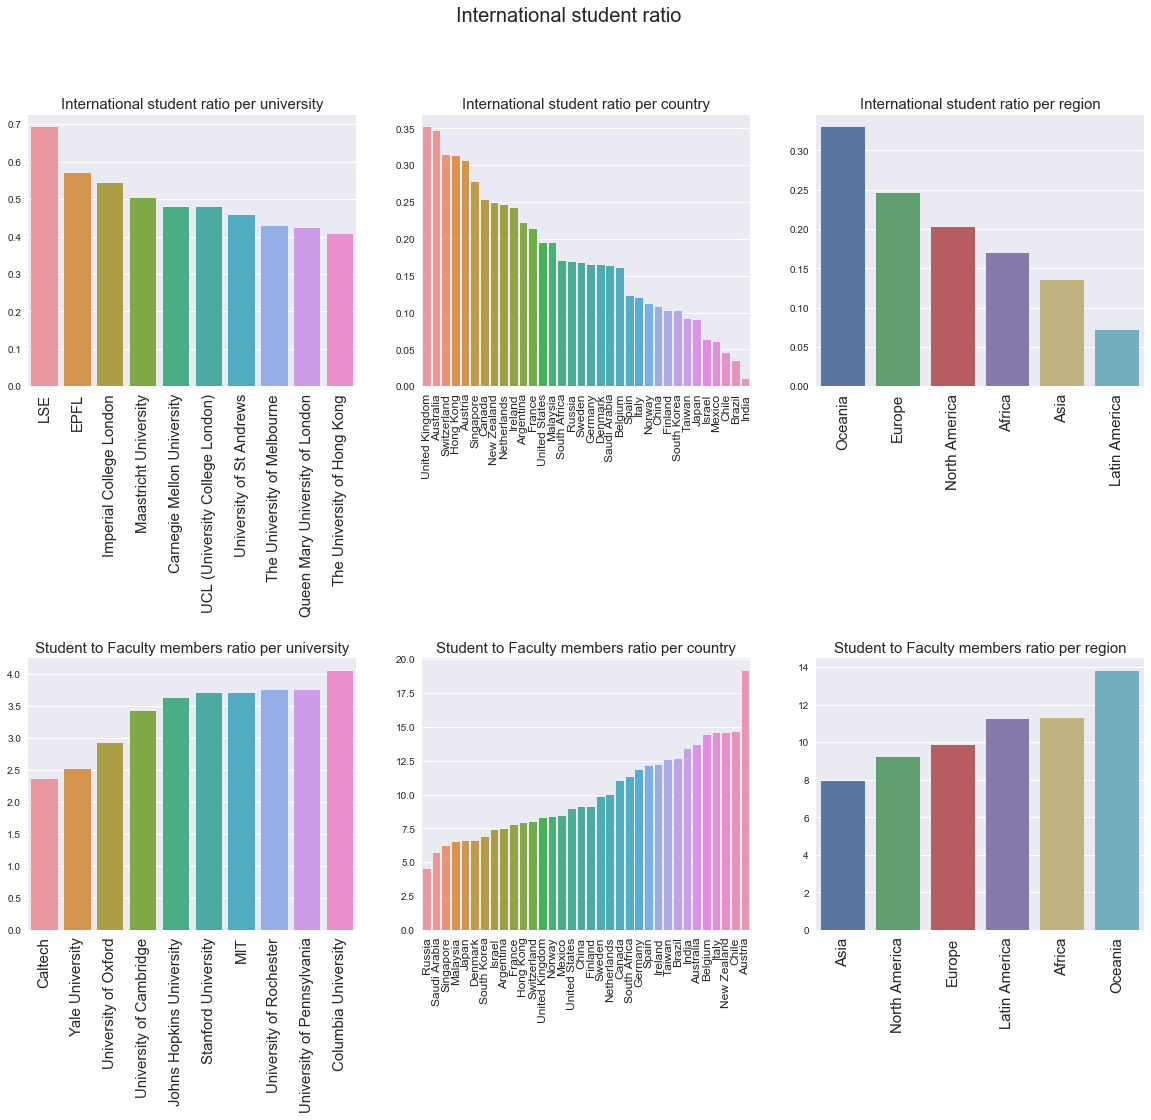

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

#creating vectors to plot
universities_IS=list(IS_ratio_df.head(10)['University'])
universities_IS[0]='LSE'  #reduce the size of the university name
universities_IS[1]='EPFL'
uni_ratios_IS=list(IS_ratio_df.head(10)['Ratio'])
universities_FS=list(FS_ratio_df.head(10)['University'])
universities_FS[0]='Caltech'
universities_FS[6]='MIT'
uni_ratios_FS=list(FS_ratio_df.head(10)['Ratio'])

countries_IS=list(IS_country_df['Country'])
country_ratios_IS= list(IS_country_df['Country mean international students ratio'])
countries_FS=list(FS_country_df['Country'])
country_ratios_FS= list(FS_country_df['Country mean student/faculty ratio'])


regions_IS=list(IS_region_df['Region'])
region_ratios_IS= list(IS_region_df['Region mean international students ratio'])
regions_FS=list(FS_region_df['Region'])
region_ratios_FS= list(FS_region_df['Region mean student/faculty ratio'])



# Create a figure with 3 subplots and set the title
fig, ax = plt.subplots(figsize=(20,15), ncols=3, nrows=2)
plt.suptitle("International student ratio", fontsize=20)


# Adjust the sub plots parameters
hspace =  1   # the amount of height reserved for white space between subplots

plt.subplots_adjust(
  hspace  =  hspace
)

# Set a title to each graph
ax[0][0].set_title("International student ratio per university", fontsize=15)
ax[0][1].set_title("International student ratio per country", fontsize=15)
ax[0][2].set_title("International student ratio per region", fontsize=15)

ax[1][0].set_title("Student to Faculty members ratio per university", fontsize=15)
ax[1][1].set_title("Student to Faculty members ratio per country", fontsize=15)
ax[1][2].set_title("Student to Faculty members ratio per region", fontsize=15)

# Plot the data
sns.barplot(universities_IS, uni_ratios_IS, ax=ax[0][0]).set_xticklabels(labels=list(universities_IS) , rotation=90, fontsize=15)
sns.barplot(countries_IS, country_ratios_IS,   ax=ax[0][1]).set_xticklabels(labels=list(countries_IS) , rotation=90, fontsize=12)
sns.barplot(regions_IS, region_ratios_IS, ax=ax[0][2]).set_xticklabels(labels=list(regions_IS) , rotation=90, fontsize=15 )
sns.barplot(universities_FS, uni_ratios_FS, ax=ax[1][0]).set_xticklabels(labels=list(universities_FS) , rotation=90, fontsize=15)
sns.barplot(countries_FS, country_ratios_FS,   ax=ax[1][1]).set_xticklabels(labels=list(countries_FS) , rotation=90, fontsize=12)
sns.barplot(regions_FS, region_ratios_FS, ax=ax[1][2]).set_xticklabels(labels=list(regions_FS) , rotation=90, fontsize=15)




The plots on the left show that the ranking for both ratios are very different. None of the 10 universities having the best students to faculty member ratio is in the 10 best universities in terms of international students. This reminds us how subjective is a ranking: there is no best university but only a best university relative to some variable.
The 2 plots in the middle are not really insightful because there are two many countries to take into account and none of them really stands out from the others. 
The plots on the right are more interesting as they can really show the differences in the education system between different regions: North America and Europe are the regions that handle the best the student to faculty members ratio and the international student ratios. Oceania has a a lot of international students but not many faculty members compared to its number of students. Latin America and Africa have quite poor results for both ratios. This could reflect the fact that Europe and North America are very developped regions whereas Latin America and Africa have many developping or under-developped countries.  



In [14]:
#Adding the ratios to the initial Total dataframe so we can take them into account for the correlations later 


Total= pd.merge(Total, FS_ratio_df[['University', 'Ratio']], on='University')
Total.rename(columns={'Ratio': 'Student/Faculty member ratio'}, inplace=True)
Total= pd.merge(Total,IS_ratio_df[['University', 'Ratio']], on='University')
Total.rename(columns={'Ratio': 'International student ratio'}, inplace=True)


# timeshighereducation.com section
Strategy for www.timeshighereducation.com:
1. Similarly as in previous task we analysed web traffic (Postman app or Developer tools) after sending GET request and found an url to the json file with all needed informations. DataFrame was created using that json file.
2. Besides data cleaning and renaming or droping attributes, no further actions were applied because of very handy json file structure.

In [15]:
times_rank_url = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(times_rank_url).json()

In [16]:
top_unis_times = pd.DataFrame.from_dict(r['data'][:200])

In [17]:
top_unis_times['stats_number_students'] = top_unis_times.stats_number_students.str.replace(",", "")

In [18]:
top_unis_times

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,20409,38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,18389,35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,2209,27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,15845,22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,11177,34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...
5,Harvard University,United States,0,Harvard University,466,6,60,private,99.7,8,...,98.4,2,84.2,9,None,20326,26%,8.9,"Agriculture & Forestry,Archaeology,Art, Perfor...",/world-university-rankings/harvard-university
6,Princeton University,United States,0,Princeton University,469,7,70,private,99.6,9,...,93.9,6,85.7,7,45 : 55,7955,24%,8.3,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/princeton-university
7,Imperial College London,United Kingdom,0,Imperial College London,472,8,80,master_account,96.7,40,...,88.7,12,81.7,13,37 : 63,15857,55%,11.4,"Biological Sciences,Chemical Engineering,Chemi...",/world-university-rankings/imperial-college-lo...
8,University of Chicago,United States,0,University of Chicago,473,9,90,private,99.4,12,...,90.1,10,85.3,8,44 : 56,13525,25%,6.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-chicago
9,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,0,ETH Zurich – Swiss Federal Institute of Techno...,479,=10,100,master_account,94.3,60,...,92.0,8,76.4,21,31 : 69,19233,38%,14.6,"Agriculture & Forestry,Architecture,Biological...",/world-university-rankings/eth-zurich-swiss-fe...


In [19]:
times_relevant_columns = ['rank', 'name', 'location',  
       'scores_citations', 'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio']

top_unis_times = top_unis_times[times_relevant_columns]

top_unis_times['rank'] = top_unis_times['rank'].str.replace("=", "").apply(pd.to_numeric)


## Now we want to obtain some information from the rankings.

We want to know which universities are the best in terms of
1. ratio between faculty and students
2. ratio of international students

We also aggregate the data based on country and region, and answer the same questions. Finally, we plot the data and desrcibe the observations.

In [20]:
# Take a look at the Times Higher Education data format
top_unis_times.head(5)

,rank,name,location,scores_citations,scores_citations_rank,scores_industry_income,scores_industry_income_rank,scores_international_outlook,scores_international_outlook_rank,scores_overall,scores_overall_rank,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,1,University of Oxford,United Kingdom,99.1,15,63.7,169,95.0,24,94.3,10,99.5,1,86.7,5,46 : 54,20409,38%,11.2
1,2,University of Cambridge,United Kingdom,97.5,29,51.5,260,93.0,35,93.2,20,97.8,3,87.8,3,45 : 55,18389,35%,10.9
2,3,California Institute of Technology,United States,99.5,10,92.6,51,59.7,322,93.0,30,97.5,4,90.3,1,31 : 69,2209,27%,6.5
3,3,Stanford University,United States,99.9,4,60.5,189,77.6,162,93.0,40,96.7,5,89.1,2,42 : 58,15845,22%,7.5
4,5,Massachusetts Institute of Technology,United States,100.0,1,88.4,63,87.6,81,92.5,50,91.9,9,87.3,4,37 : 63,11177,34%,8.7


Now, we sort the values based on stats_student_staff_ratio, which is **the number of students per faculty**. In this context, the smaller the number the better, because there will be fewer students per one faculty member, i.e. there will be more faculty per one student (and we assume that the more support and research staff there is for each student, the better the student's situation, which is a very natural assumption).

We see that the best university in this regard is Vanderbilt University, which has 3.3 students per one faculty member.

In [21]:
top_unis_times['stats_student_staff_ratio'] = top_unis_times['stats_student_staff_ratio'].apply(pd.to_numeric)
best_faculty_ratio = top_unis_times['stats_student_staff_ratio'].sort_values().head(10)
best_faculty_ratio.index
top_unis_times.loc[best_faculty_ratio.index][['name','rank','stats_student_staff_ratio']]

,name,rank,stats_student_staff_ratio
105,Vanderbilt University,105,3.3
109,University of Copenhagen,109,4.1
12,Johns Hopkins University,13,4.3
11,Yale University,12,4.3
153,University of Rochester,153,4.3
97,Emory University,98,4.4
16,Duke University,17,4.5
114,École Polytechnique,115,5.1
183,Scuola Normale Superiore di Pisa,184,5.2
101,University of Pittsburgh,100,5.9


Now, we want to know which universities are the best with respect to **the percentage of international students**. In our data, the percentage can be found in the column stats_pc_intl_students, which is directly the percentage of international students. Here it is not very clear what _the best_ means. One assumption is that the larger the percentage of international students the better, but it is also valid to say the smaller the percentage the better. Therefore, we analyze both assumptions.
We find that
1. If larger percentage is better, the London School of Economics and Political Science is the best with 71 % of the students being international
2. If smaller percentage is better, the University of Science and Technology of China is the best with 3 % of the students being international.

In [22]:
top_unis_times['stats_pc_intl_students'].dtype
top_unis_times['stats_pc_intl_students'] = top_unis_times['stats_pc_intl_students'].str.strip('%').apply(pd.to_numeric)

In [23]:
best_intl_desc = top_unis_times['stats_pc_intl_students'].sort_values(ascending=False).head(10)
best_intl_asc = top_unis_times['stats_pc_intl_students'].sort_values(ascending=True).head(10)

In [24]:
top_unis_times.loc[best_intl_desc.index][['name','rank','stats_pc_intl_students']]

,name,rank,stats_pc_intl_students
24,London School of Economics and Political Science,25,71
178,University of Luxembourg,179,57
7,Imperial College London,8,55
37,École Polytechnique Fédérale de Lausanne,38,55
102,Maastricht University,103,50
15,University College London,16,49
143,University of St Andrews,143,48
120,Queen Mary University of London,121,45
23,Carnegie Mellon University,24,45
39,University of Hong Kong,40,42


In [25]:
top_unis_times.loc[best_intl_asc.index][['name','rank','stats_pc_intl_students']]

,name,rank,stats_pc_intl_students
131,University of Science and Technology of China,132,3
161,"University of California, Santa Cruz",162,4
136,Pohang University of Science and Technology,137,4
188,Shanghai Jiao Tong University,188,6
177,Zhejiang University,177,6
167,University of Alabama at Birmingham,168,6
89,University of Helsinki,90,6
183,Scuola Normale Superiore di Pisa,184,7
173,University of Münster,173,7
67,Utrecht University,68,7


## Aggregating by country
We aggregate the data first based on country, which is readily available in our data set. We group the data points (universities) based on the location feature (their country), and take the mean over numerical features. This mean value is the aggregated value for the country. Then, we compare the countries to each other based on the aggregate value.

We find that the Russian Federation (Russia) is the best country with respect to the number of faculty per students, with a mean of 7.3 students per one faculty member.

In [26]:
times_by_country = top_unis_times.groupby(by='location').mean()

times_by_country['stats_student_staff_ratio'].sort_values().head(10)

location
Russian Federation     7.300000
Japan                  7.700000
Denmark                8.133333
Italy                  8.450000
Taiwan                11.500000
South Africa          11.700000
United States         11.904839
China                 11.942857
South Korea           13.300000
France                13.450000
Name: stats_student_staff_ratio, dtype: float64

For the percentage of international students, we do the evaluation of the aggregate values based on the two assumptions which we used in the non-aggregated case. We find that
1. If larger percentage is better, Luxembourg is the best with a mean of 57 % of the students being international
2. If smaller percentage is better, Taiwan is the best with a mean of 8 % of the students being international

In [27]:
times_by_country['stats_pc_intl_students'].sort_values(ascending=False).head(10)

location
Luxembourg        57.000000
United Kingdom    36.548387
Hong Kong         32.800000
Switzerland       31.428571
Australia         30.750000
Singapore         30.500000
New Zealand       29.000000
Ireland           27.000000
Austria           26.000000
Canada            22.500000
Name: stats_pc_intl_students, dtype: float64

In [28]:
times_by_country['stats_pc_intl_students'].sort_values(ascending=True).head(10)

location
Taiwan          8.000000
China           8.571429
Japan           9.000000
South Korea     9.000000
Italy          10.500000
Finland        13.000000
Spain          14.000000
Sweden         14.000000
Germany        15.200000
Denmark        16.666667
Name: stats_pc_intl_students, dtype: float64

## Aggregating by region
The Times Higher Education data does not contain region information, just the country. Therefore we need to infer the region from country. To do this, we use the topuniversities.com data set which contains both countries and regions to map countries in the Times Higher Education data set to regions.

We construct a dictionary where keys are countries and values are their respective regions based on the topuniversities.com data set, and use this dictionary to map the country of each university in the Times Higher Education data set to a region. The region information is saved in the new feature _region_\__the_.

We then check if there are universities which didn't get a region. We find two such occurrences, a university in Luxembourg and a university in the Russian Federation. The former not receiving a region is due to the fact that no universities in Luxembourg were found in the topuniversities.com data set, and the latter not receiving a region is due to the Russian Federation being named simply Russia in the topuniversities.com data set. Since there are only two problems, we fix them by hand, assigning both to Europe.

We find that:
1. Africa is the best region with respect to the number of faculty per students, with a mean of 11.7 students per one faculty member
2. If larger percentage is better, Oceania is the best region with respect to the percentage of international students, with a mean of 30.6 % of the students being international
3. If smaller percentage is better, Asia is the best region with respect to the percentage of international students, with a mean of 16.5 % of the students being international

In [29]:
top_unis_times['region_the'] = np.nan

country_region_map = {}
for index,entry in top_unis.iterrows():
    if entry['country'] not in country_region_map:
        country_region_map[entry['country']] = entry['region']

# The mapping
country_region_map

{'Argentina': 'Latin America',
 'Australia': 'Oceania',
 'Austria': 'Europe',
 'Belgium': 'Europe',
 'Brazil': 'Latin America',
 'Canada': 'North America',
 'Chile': 'Latin America',
 'China': 'Asia',
 'Denmark': 'Europe',
 'Finland': 'Europe',
 'France': 'Europe',
 'Germany': 'Europe',
 'Hong Kong': 'Asia',
 'India': 'Asia',
 'Ireland': 'Europe',
 'Israel': 'Asia',
 'Italy': 'Europe',
 'Japan': 'Asia',
 'Malaysia': 'Asia',
 'Mexico': 'Latin America',
 'Netherlands': 'Europe',
 'New Zealand': 'Oceania',
 'Norway': 'Europe',
 'Russia': 'Europe',
 'Saudi Arabia': 'Asia',
 'Singapore': 'Asia',
 'South Africa': 'Africa',
 'South Korea': 'Asia',
 'Spain': 'Europe',
 'Sweden': 'Europe',
 'Switzerland': 'Europe',
 'Taiwan': 'Asia',
 'United Kingdom': 'Europe',
 'United States': 'North America'}

In [30]:
# Give a region for each university in the Times Higher Education data set based on the country
for index,entry in top_unis_times.iterrows():
    if entry['location'] in country_region_map:
        top_unis_times.loc[index,'region_the'] = country_region_map[entry['location']]
        
# Check which universities didn't get a region (gives indices)
for index,row in enumerate(top_unis_times['region_the'].isnull()):
    if row != False:
        print(index)

178
193


In [31]:
top_unis_times.loc[[178,193]][['name','location','region_the']]

# Luxembourg is not included and Russian Federation is written as Russia in the topuniversities.com data

,name,location,region_the
178,University of Luxembourg,Luxembourg,NaN
193,Lomonosov Moscow State University,Russian Federation,NaN


In [59]:
top_unis_times.loc[178,'region_the'] = 'Europe'
top_unis_times.loc[193,'region_the'] = 'Europe'

# Check that all universities have received a region
print('All universities have a region: ' + str(not top_unis_times['region_the'].isnull().any()))

top_unis_times.loc[[178,193]][['name','location','region_the']]

All universities have a region: True


,name,location,region_the
178,University of Luxembourg,Luxembourg,Europe
193,Lomonosov Moscow State University,Russian Federation,Europe


In [33]:
times_by_region = top_unis_times.groupby(by='region_the').mean()

# Students per faculty
times_by_region['stats_student_staff_ratio'].sort_values().head()

region_the
Africa           11.700000
North America    12.594118
Asia             13.976190
Europe           21.371287
Oceania          26.500000
Name: stats_student_staff_ratio, dtype: float64

In [34]:
# Percentage of international students, descending
times_by_region['stats_pc_intl_students'].sort_values(ascending=False)

region_the
Oceania          30.555556
Europe           24.465347
North America    18.558824
Africa           18.000000
Asia             16.523810
Name: stats_pc_intl_students, dtype: float64

In [35]:
# Percantage of international students, ascending
times_by_region['stats_pc_intl_students'].sort_values(ascending=True)

region_the
Asia             16.523810
Africa           18.000000
North America    18.558824
Europe           24.465347
Oceania          30.555556
Name: stats_pc_intl_students, dtype: float64

## Plotting the results and observations
We plot the above results using bar graphs, using the top 10 universities, top 10 countries, and all regions represented in the data (since there are only five). To reduce the number of plots and make reading easier, we assume that a larger percentage of international students is better (before, we showed results for both assuming larger is better and assuming smaller is better).

We observe that even though all top ten universities in the number of faculty per student are either European or in the United States, the best country by mean is Russia and the best region by mean is Africa. This is due to the low number of Russian and African universities in the data set compared to European and American universities. The mean for each European country and United States can be lower even though top universities come from these countries, because there are so many other universities from the same country that can reduce the effect the top ones have on the mean.

We also observe that eight out of ten best universities with respect to the number of international students are from Europe. This might be due to the number of different countries in Europe in close proximity to each other, so that it is easy to move to another country to study. In contrast, for example in North America there are far fewer countries, and students might rather move within their own country. However, by region Oceania has the largest mean number of international students (and not Europe), which could be due to a) only some select universities attracting international students in Europe, and/or b) the small number of Oceanian universities in the data compared to European ones gives much more weight to the few very well performing universities in Oceania and less weight to the few very well performing universities in Europe. We see this in comparison by country: Luxembourg has only one university in the data set, which makes its mean percentage of international students clearly stand out much higher than the rest of the top ten countries.

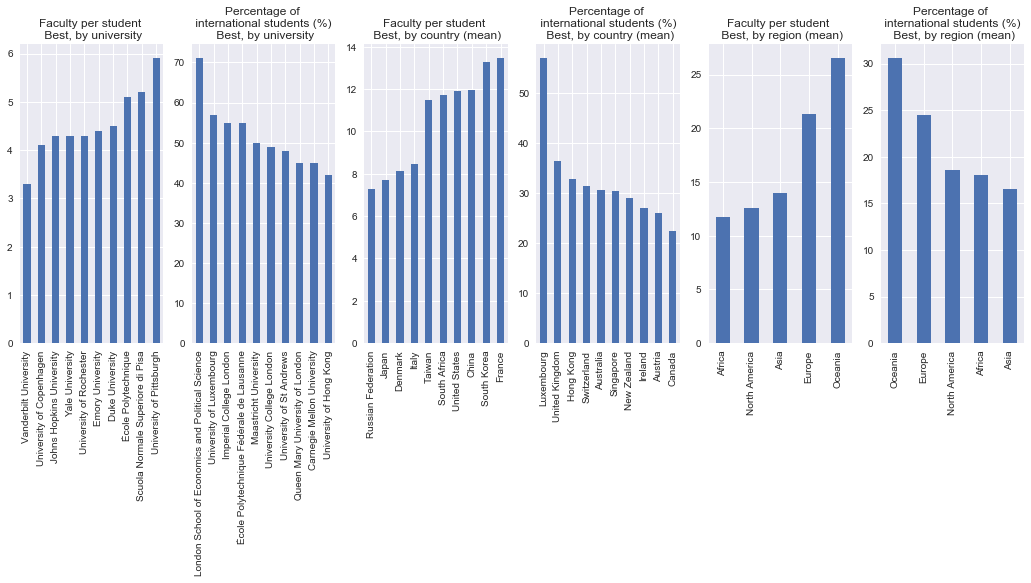

In [36]:
fig,axs = plt.subplots(1,6)
fig.set_figwidth(18)

plt.sca(axs[0])
best_faculty_ratio.plot(kind='bar')
plt.xticks(range(0,10),list(top_unis_times.loc[best_faculty_ratio.index]['name'].values))
plt.title('Faculty per student \n Best, by university')

plt.sca(axs[1])
best_intl_desc.plot(kind='bar')
plt.xticks(range(0,10),list(top_unis_times.loc[best_intl_desc.index]['name'].values))
plt.title('Percentage of \n international students (%) \n Best, by university')

plt.sca(axs[2])
times_by_country['stats_student_staff_ratio'].sort_values().head(10).plot(kind='bar')
plt.title('Faculty per student \n Best, by country (mean)')
plt.xlabel('')

plt.sca(axs[3])
times_by_country['stats_pc_intl_students'].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Percentage of \n international students (%) \n Best, by country (mean)')
plt.xlabel('')

plt.sca(axs[4])
times_by_region['stats_student_staff_ratio'].sort_values().plot(kind='bar')
plt.title('Faculty per student \n Best, by region (mean)')
plt.xlabel('')

plt.sca(axs[5])
times_by_region['stats_pc_intl_students'].sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of \n international students (%) \n Best, by region (mean)')
plt.xlabel('')

plt.show()

# Merging both ranking DataFrames
Strategy:
1. We checked how many of university names overlap (105).
2. We looked at those which were not matched and found out that many of them have an abbreviation at the end, so we deleted them using regex to find every string that contains parentheses, for example '(MIT)' or '(EPFL)'.
3. After that operation there were 119 matched universities.
4. Another differentiating thing was the word `The` at the beginning of universities' names (139 matched).
5. At the end we used difflib library and its `get_close_matches` function iteratively with different cutoff parameter to find best matches between not matched names. That part required more manual assigning.
6. We ended up with 160 matched universities.
7. Merging was made on respectively `name` and `title` columns.

In [37]:
matching_names_total_in_times = np.array([title in top_unis_times['name'].values for title in Total['University'].values])
matching_names_total_in_times

array([False,  True,  True, False,  True,  True, False,  True,  True,
       False, False, False,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False, False,  True, False, False,
       False,  True, False,  True,  True, False, False, False,  True,
        True,  True, False,  True, False, False, False,  True, False,
       False, False,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
        True,  True, False,  True, False,  True,  True, False,  True,
        True,  True, False, False, False,  True,  True, False,  True,
       False, False,  True, False, False,  True, False,  True, False,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
        True,  True, False, False, False, False, False, False,  True,
        True, False,

This names were not matched between `Total` and `top_unis_times`

In [38]:
not_matched = Total[~matching_names_total_in_times].University.values
print(len(not_matched))

95


In [39]:
Total.loc[Total['University'] == 'UCL (University College London)', 'University'] = 'University College London'
top_unis_times.loc[top_unis_times['name'] == 'ETH Zurich – Swiss Federal Institute of Technology Zurich'
                   , 'name'] = 'ETH Zurich - Swiss Federal Institute of Technology'
Total.loc[Total['University'] == 'Ecole Polytechnique Fédérale de Lausanne (EPFL)', 'University'] = 'École Polytechnique Fédérale de Lausanne'

In [40]:
for not_match in not_matched:
    Total.loc[Total['University'] == not_match, 'University'] = re.sub(r"\((.*?)\)", "" , not_match).strip()

In [41]:
matching_names_total_in_times_2 = np.array([title in top_unis_times['name'].values for title in Total['University'].values])
print(np.count_nonzero(matching_names_total_in_times_2))

119


Plenty of names differ only by a `The` at the beginning of a `name`

In [42]:
similar = [(elem, difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.7)[0]) for elem in Total[~matching_names_total_in_times_2].University.values if difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.7) != []]
len(similar)

55

In [43]:
for not_match in Total[~matching_names_total_in_times_2].University.values:
    Total.loc[Total['University'] == not_match, 'University'] = re.sub(r"^(The)\s", "" , not_match)

In [44]:
matching_names_total_in_times_3 = np.array([title in top_unis_times['name'].values for title in Total['University'].values])
print(np.count_nonzero(matching_names_total_in_times_3))

139


In [45]:
similar2 = [(elem, difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.4)[0]) 
            for elem in Total[~matching_names_total_in_times_3].University.values 
            if difflib.get_close_matches(elem, top_unis_times['name'].values, cutoff = 0.4) != []]

In [46]:
names = [("King's College London", 'King’s College London'),
         ('KAIST - Korea Advanced Institute of Science & Technology',
          'Korea Advanced Institute of Science and Technology (KAIST)'),
         ('Ecole Polytechnique', 'École Polytechnique'),
         ('Pohang University of Science And Technology',
          'Pohang University of Science and Technology'),
         ('University of North Carolina, Chapel Hill',
          'University of North Carolina at Chapel Hill'),
         ('Washington University in St. Louis', 'Washington University in St Louis'),
         ('KIT, Karlsruhe Institute of Technology',
          'Karlsruhe Institute of Technology'),
         ('Humboldt-Universität zu Berlin', 'Humboldt University of Berlin'),
         ('Freie Universitaet Berlin', 'Free University of Berlin'),
         ('Université de Montréal', 'University of Montreal'),
         ('Technische Universität Berlin', 'Technical University of Berlin'),
         ('Université catholique de Louvain', 'Université Catholique de Louvain'),
         ('Trinity College Dublin, The University of Dublin',
          'Trinity College Dublin'),
         ("Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento",
          'Scuola Superiore Sant’Anna'),
         ('Universitat Autònoma de Barcelona', 'Autonomous University of Barcelona'),
         ('Eberhard Karls Universität Tübingen', 'University of Tübingen')]
         
for total_name, top_unis_name in names:        
    Total.loc[Total['University'] == total_name, 'University'] = top_unis_name

In [47]:
matching_names_total_in_times_4 = np.array([title in top_unis_times['name'].values for title in Total['University'].values])
print(np.count_nonzero(matching_names_total_in_times_4))

155


In [48]:
matching_names_times_in_total = np.array([title in Total['University'].values for title in top_unis_times['name'].values])
print(np.count_nonzero(matching_names_times_in_total))

155


In [49]:
similar3 = [(elem, difflib.get_close_matches(elem, top_unis_times[~matching_names_times_in_total].name.values, cutoff = 0.2)) 
            for elem in Total[~matching_names_total_in_times_4].University.values]

In [50]:
names2 = [('Ludwig-Maximilians-Universität München', 'LMU Munich'),
         ('Ruprecht-Karls-Universität Heidelberg', 'Heidelberg University'),
         ('Université Pierre et Marie Curie', 'Pierre and Marie Curie University'),
         ('Wageningen University', 'Wageningen University & Research'),
         ('Albert-Ludwigs-Universitaet Freiburg', 'University of Freiburg')]

for total_name, top_unis_name in names2:        
    Total.loc[Total['University'] == total_name, 'University'] = top_unis_name

In [51]:
matching_names_times_in_total = np.array([title in Total['University'].values for title in top_unis_times['name'].values])
print(np.count_nonzero(matching_names_times_in_total))

160


In [52]:
Full_ranking = Total.merge(top_unis_times, left_on='University', right_on='name', how='inner')

Full_ranking.rename(columns={'rank': 'THE Ranking', 'title': 'University', 'country':'Country', 'region': 'Region'}, inplace=True)

print(Full_ranking.columns)
Full_ranking[['University','TopUni Ranking', 'THE Ranking']].head()

Index(['TopUni Ranking', 'University', 'Country', 'Region', 'url', 'nid',
       'Academic Reputation', 'Citations per Faculty', 'Employer Reputation',
       'Faculty Student', 'International Faculty', 'International Students',
       'International faculty members', 'Overall Score',
       'Postgraduate international students [%]', 'Postgraduate students [%]',
       'Total faculty members', 'Total international students',
       'Total number of students', 'Undergraduate international students [%]',
       'Undergraduate students [%]', 'age_value', 'data_status_value',
       'research_intensity_value', 'size_value', 'subject_range_value',
       'Student/Faculty member ratio', 'International student ratio',
       'THE Ranking', 'name', 'location', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank

,University,TopUni Ranking,THE Ranking
0,Massachusetts Institute of Technology,1,5
1,Stanford University,2,3
2,Harvard University,3,6
3,California Institute of Technology,4,3
4,University of Cambridge,5,2


In [53]:
#Total['TopUni Ranking'] = Total['TopUni Ranking'].apply(pd.to_numeric)
#Total['age_value'] = Total['age_value'].astype('category')
#Total['data_status_value'] = Total['data_status_value'].astype('category')
#Total['research_intensity_value'] = Total['research_intensity_value'].astype('category')
#Total['size_value'] = Total['size_value'].astype('category')
#Total['subject_range_value'] = Total['subject_range_value'].astype('category')

In [54]:
#cat_columns = Total.select_dtypes(['category']).columns
#Total[cat_columns] = Total[cat_columns].apply(lambda x: x.cat.codes)

In [55]:
#Total.dtypes

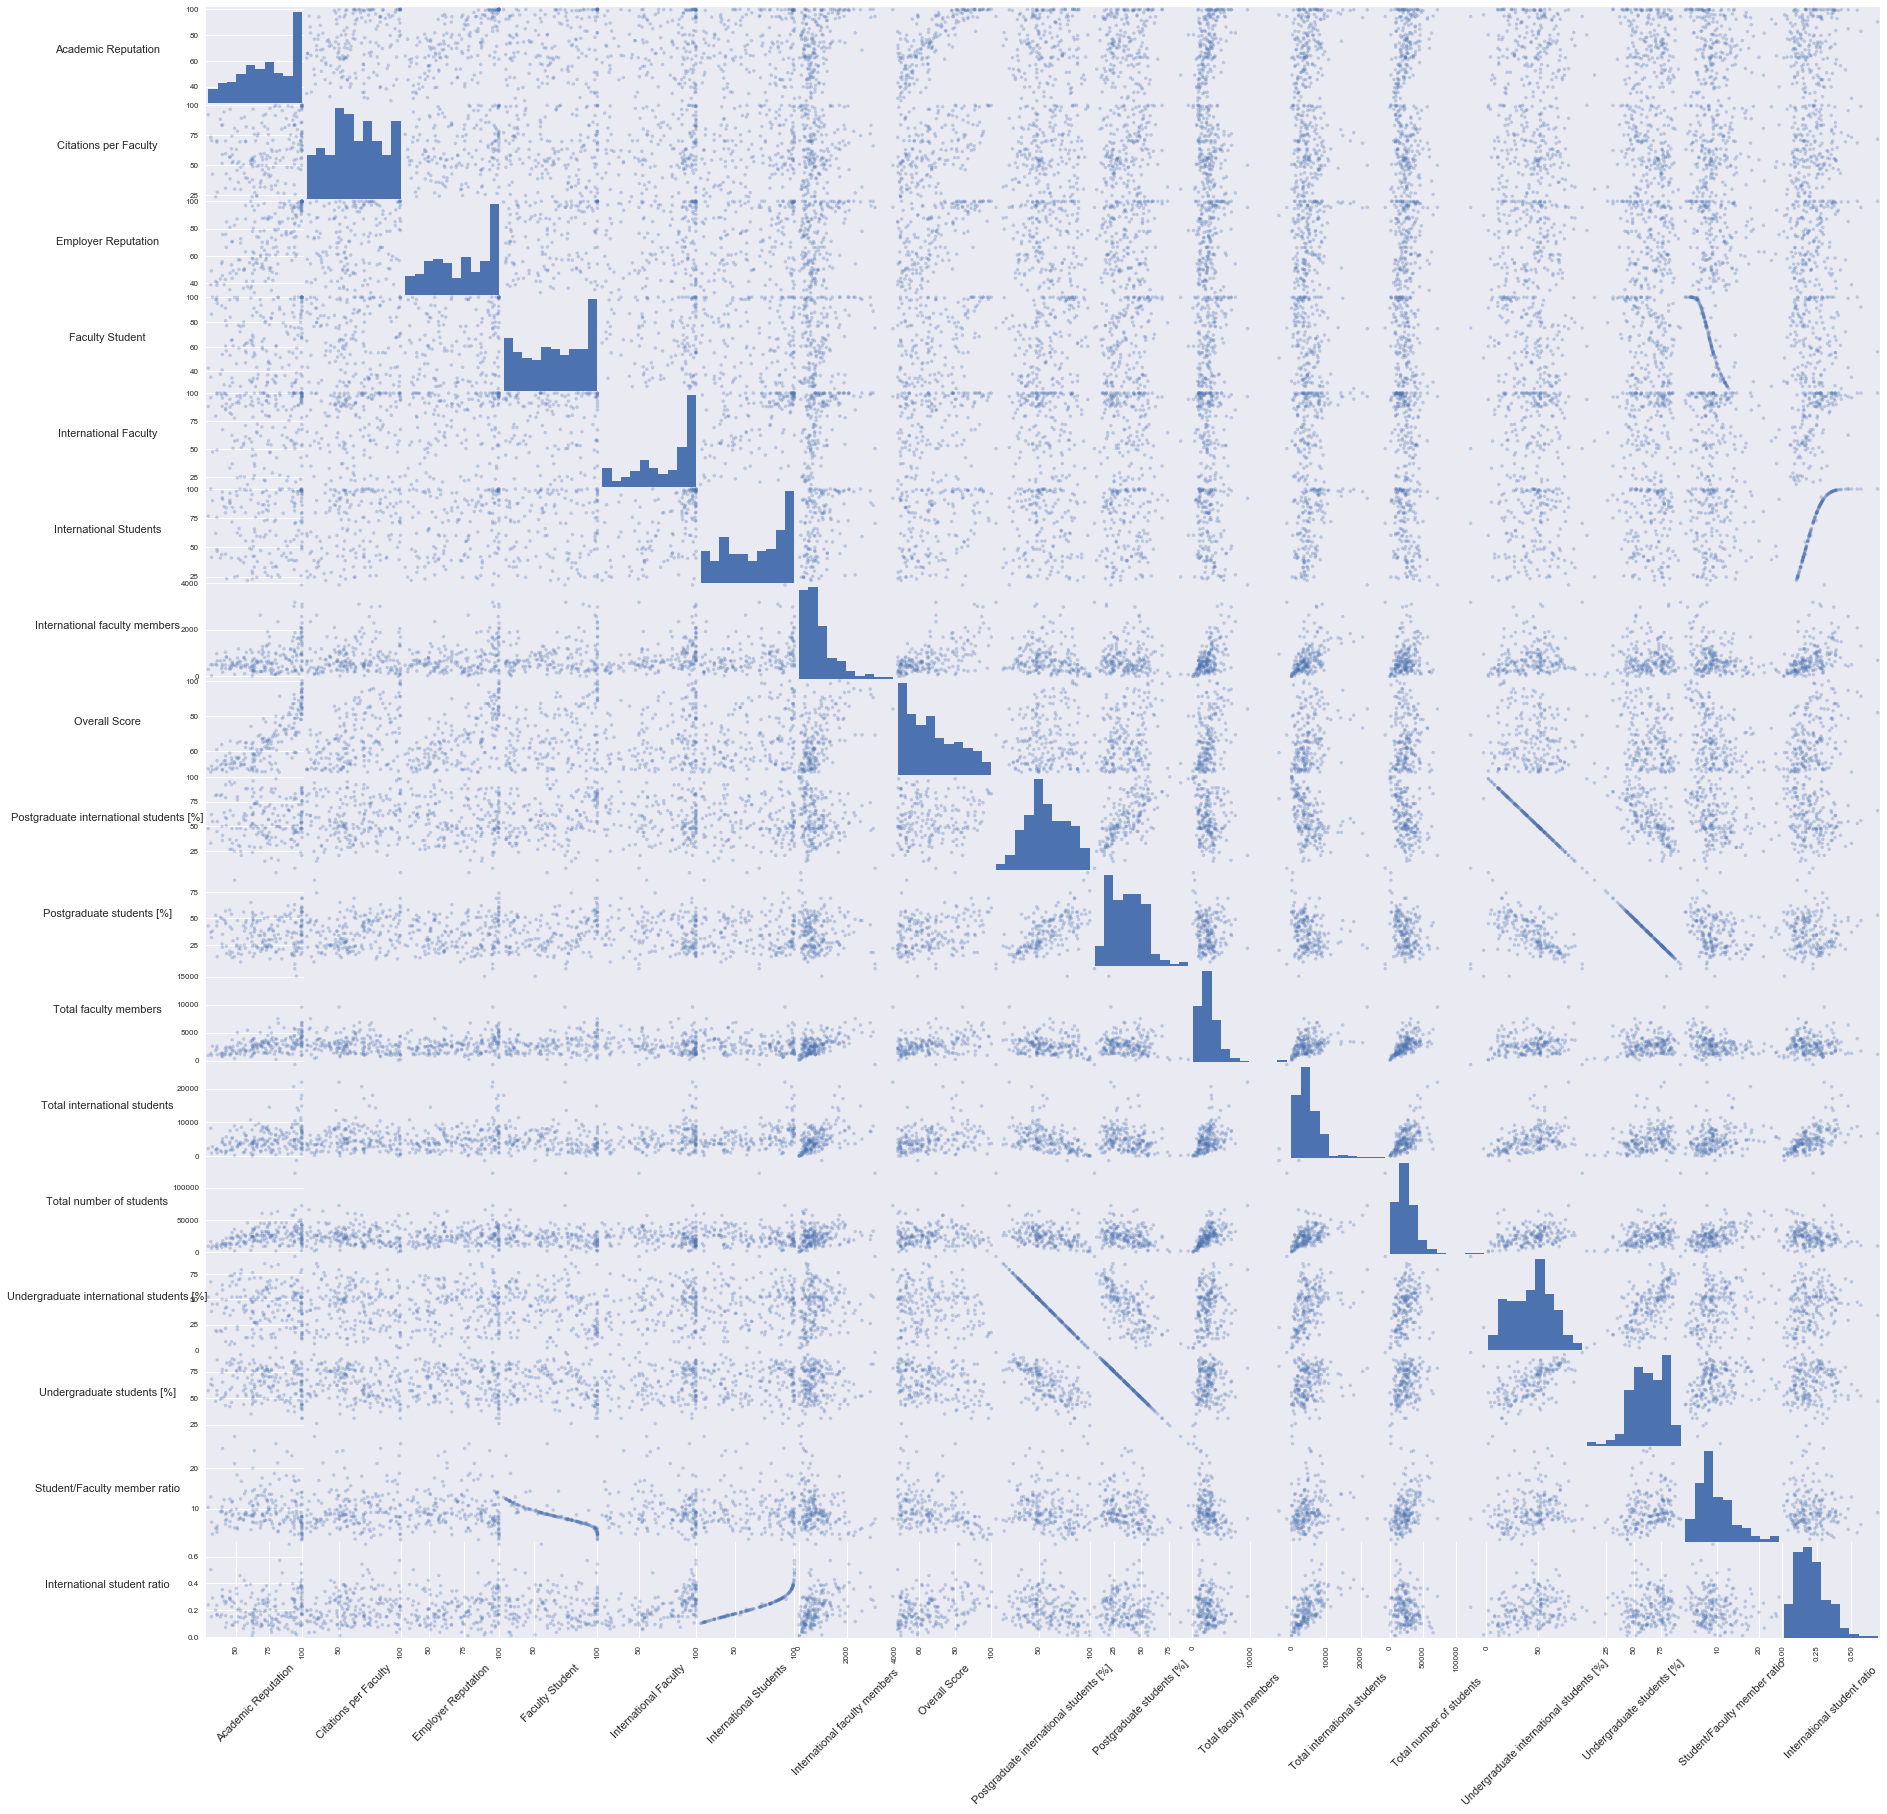

In [56]:
sm = scatter_matrix(Total, alpha=0.3, figsize=(30, 30), diagonal='hist')
#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

#Hide all ticks
#[s.set_xticks(()) for s in sm.reshape(-1)]
#[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

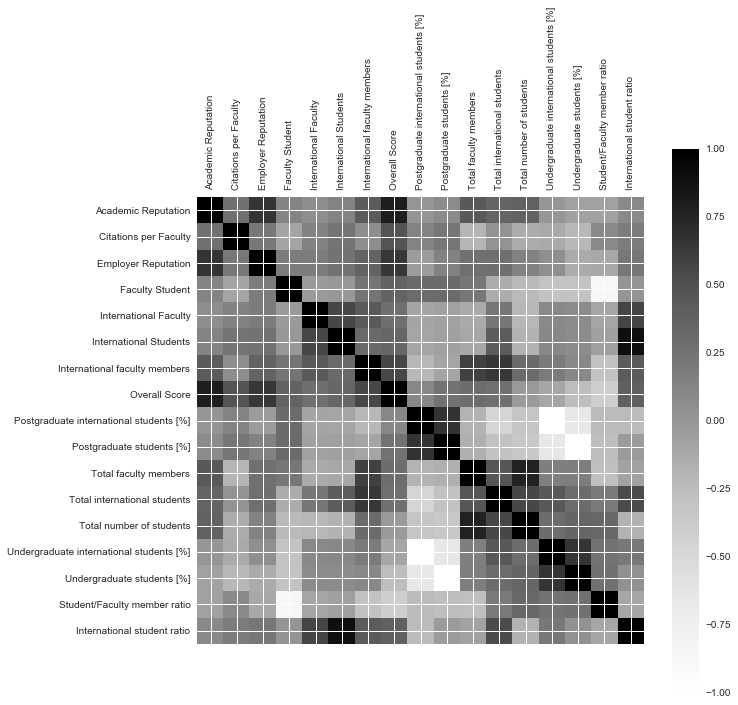

In [57]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    x = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.xticks(rotation=90)
    plt.colorbar(x)
Total.columns
plot_corr(Total)

This matrix shows that the overall score seems to be strongly correlated to the academic reputation and employer reputation. This can witness the fact that many people trust the rankings and therefore their judgment on universities will be a function of the position in some ranking. 
But this reputation will be taken into account when the ranking is created so this could leed to the following: it might be very difficult for lower down universities to go up in the ranking but very easy for high up universities to stay up. This can shows that the reputation might not be a relevant/unbiased parameter in universities ranking.

# Question 5

Choose the best university taking into account both rankings by taking the **mean of both rankings** and comparing that value to other universities.

In [58]:
#create a table with only the values for the two rankings 
Full_ranking['TopUni Ranking'] = Total['TopUni Ranking'].apply(pd.to_numeric)
Sorted_ranking = Full_ranking[['University','TopUni Ranking','THE Ranking']]

#Create a new column with the mean of the position in both rankings and sort the table by this value
Sorted_ranking['Mean ranking']=(Sorted_ranking['TopUni Ranking']+Sorted_ranking['THE Ranking'])/2
Sorted_ranking = Sorted_ranking.sort_values(by='Mean ranking')
Sorted_ranking.head()

,University,TopUni Ranking,THE Ranking,Mean ranking
1,Stanford University,2,3,2.5
0,Massachusetts Institute of Technology,1,5,3.0
3,California Institute of Technology,4,3,3.5
4,University of Cambridge,5,2,3.5
5,University of Oxford,6,1,3.5


Stanford is the university that has the highest mean ranking. Because the two rankings use different parameters to rank the universities, we can consider that taking into account the positions in both ranking can give a good insight on how good this university is. Following this idea, Stanford would be the best university. 